In [1]:
!pip install tensorflow==2.17.0 opencv-python matplotlib


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
# Avoid OOM errors by setting GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
# Making the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

FileExistsError: [WinError 183] Cannot create a file when that file already exists: 'data\\positive'

In [ ]:
# Incompress the labelled faces in the wild dataset
!tar -xf lfw.tgz

In [ ]:
# Move LFW images from the exisitng repository to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [5]:
# Import uuid
import uuid

In [8]:
import time

# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    if not ret:
        print("Failed to grab frame")
        break
        
    # Cut down to 250x250
    frame = frame[120:120+250, 200:200+250, :]

    # Show image back to screen
    cv2.imshow('Image Collection', frame)

    # Wait for the key press
    key = cv2.waitKey(1) & 0XFF
    
    # Capturing anchors
    if key == ord('a'):
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
            

    # Capturing positives
    if key == ord('p'):
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        cv2.imwrite(imgname, frame)
           

    # Breaking gracefully when 'q' is pressed
    if key == ord('q'):
        break

# Release the webcam
cap.release()

# Close the image show frame
cv2.destroyAllWindows()

In [11]:
# Load an image from a file
img = cv2.imread('data/anchor/00b5eae7-92ac-11ef-8d26-f209a11ea55b.jpg')
# Display the image in a window
cv2.imshow('Image', img)

# Wait indefinitely until a key is pressed
cv2.waitKey(0)

# Close the window
cv2.destroyAllWindows()

In [6]:
# Get image directories
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [7]:
dir_test = anchor.as_numpy_iterator()

In [9]:
dir_test.next()

b'data\\anchor\\30f6b2c7-92ac-11ef-bad9-f209a11ea55b.jpg'

In [64]:
# Image preprocessing function - Scale and Resize
def preprocess(file_path):

  # Read in image from file path
  byte_img = tf.io.read_file(file_path)
  # Load in the image
  img = tf.io.decode_jpeg(byte_img)
  # Preprocessing the image - resizing the image to be 100x100x3
  img = tf.image.resize(img, (100, 100))
  # Scale image to be between 0 and 1
  img = img / 255.0
  # Return image
  return img

In [11]:
img = preprocess('data\\anchor\\4433752d-92ac-11ef-8043-f209a11ea55b.jpg')

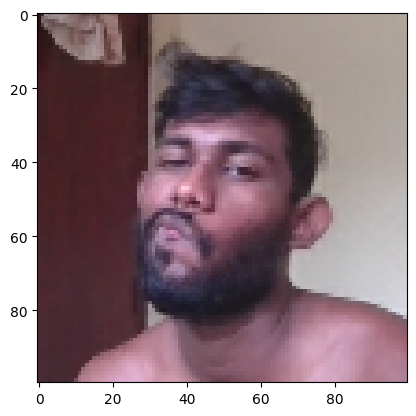

In [13]:
plt.imshow(img)

In [14]:
img.numpy().max()

1.0

In [15]:
img.numpy().min()

0.071078435

In [16]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

In [17]:
# Creating labelled dataset

positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [18]:
samp[1]

NameError: name 'samp' is not defined

In [19]:
# Preprocess the dataset
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [20]:
# Dataloader pipelien

data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [21]:
samples = data.as_numpy_iterator()
len(samples.next())

3

In [22]:
samples = data.as_numpy_iterator()

In [23]:
samp = samples.next()

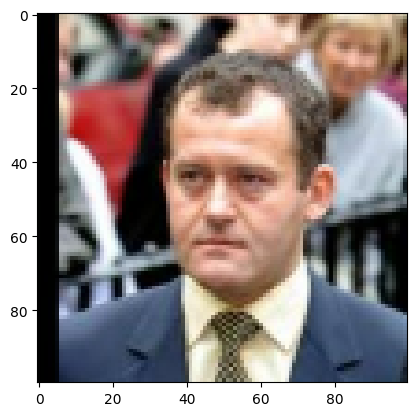

In [24]:
plt.imshow(samp[1])

In [25]:
# Training partition

train_data = data.take(round(len(data)*.7))

# Passing the data as batch of 16 images
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [26]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [27]:
# Tesing partition
test_data = data.skip(round(len(data)*.7)) # Skipping train 70% data
test_data = test_data.take(round(len(data)*.3)) # Grabbing the last 30% data as test partition
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [31]:
# Embedding layer

def make_embedding():
    inp = Input(shape=(100,100,3), name='input_image') # Input Layer

    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp) # Convolution Layer
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1) # Max pooling layer

    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

    # Third block
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)

    return Model(inputs=[inp], outputs=[d1], name='embedding' )

In [32]:
embedding = make_embedding()
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [33]:
# Siamese L1 Distance layer
class L1Dist(Layer):

  # Init method - inheritance  
  def __init__(self, **kwargs):
    super().__init__()

  # Similarity calculation
  def call(self, input_embedding, validation_embedding):
    # Converting to tensors (1, None, 4096)  
    input_embedding = tf.convert_to_tensor(input_embedding)
    validation_embedding = tf.convert_to_tensor(validation_embedding)
    
    l1_distance =  tf.math.abs(input_embedding - validation_embedding)
    # Removing a dimension - output shape: (None, 4096)   
    l1_distance = tf.squeeze(l1_distance, axis=0)   
    return l1_distance  

In [34]:
def make_siamese_model():
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))

    # Validation image in the network
    validation_image = Input(name='validation_img', shape=(100,100,3))

    # Generate embeddings
    embedding_input = embedding(input_image)
    embedding_validation = embedding(validation_image)
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding_input, embedding_validation)
    
    # Classification Layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [35]:
siamese_model = make_siamese_model()

In [36]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist (L1Dist)    │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
# Loss function
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [38]:
# Optimizer(Adam) - can use any Keras optimizer
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [39]:
# Establish checkpoints
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [40]:
test_batch = train_data.as_numpy_iterator()

In [41]:
batch_1 = test_batch.next()

In [42]:
x = batch_1[:2]
np.array(x).shape

(2, 16, 100, 100, 3)

In [43]:
# Train step function
@tf.function
def train_step(batch):

    # Record all operations
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative imgae
        x = batch[:2]
        # Get label
        y = batch[2]
    
        # Forward pasee
        yhat = siamese_model(x, training=True)  # Certain layers will only activate only if 'training=True'
        # Calculate loss
        loss = binary_cross_loss(y, yhat)

    tf.print("Loss:", loss)
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    pass

In [44]:
# Train loop
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}' .format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

In [45]:
EPOCHS = 10

In [46]:
train(train_data, EPOCHS)


 Epoch 1/10
Loss: 0.692357421
 1/27 ━━━━━━━━━━━━━━━━━━━━ 57s 2s/stepLoss: 0.679703593
 2/27 ━━━━━━━━━━━━━━━━━━━━ 19s 770ms/stepLoss: 0.631810188
 3/27 ━━━━━━━━━━━━━━━━━━━━ 18s 761ms/stepLoss: 0.628824234
 4/27 ━━━━━━━━━━━━━━━━━━━━ 17s 755ms/stepLoss: 0.528859079
 5/27 ━━━━━━━━━━━━━━━━━━━━ 16s 752ms/stepLoss: 0.554662287
 6/27 ━━━━━━━━━━━━━━━━━━━━ 15s 757ms/stepLoss: 0.528809369
 7/27 ━━━━━━━━━━━━━━━━━━━━ 15s 761ms/stepLoss: 0.355301142
 8/27 ━━━━━━━━━━━━━━━━━━━━ 14s 761ms/stepLoss: 0.512175918
 9/27 ━━━━━━━━━━━━━━━━━━━━ 13s 758ms/stepLoss: 0.319622576
10/27 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/stepLoss: 0.386834562
11/27 ━━━━━━━━━━━━━━━━━━━━ 12s 756ms/stepLoss: 0.321186841
12/27 ━━━━━━━━━━━━━━━━━━━━ 11s 756ms/stepLoss: 0.465750784
13/27 ━━━━━━━━━━━━━━━━━━━━ 10s 755ms/stepLoss: 0.351244569
14/27 ━━━━━━━━━━━━━━━━━━━━ 9s 754ms/step Loss: 0.26581642
15/27 ━━━━━━━━━━━━━━━━━━━━ 9s 755ms/stepLoss: 0.393361926
16/27 ━━━━━━━━━━━━━━━━━━━━ 8s 756ms/stepLoss: 0.350634187
17/27 ━━━━━━━━━━━━━━━━━━━━ 7s 7

In [47]:
from tensorflow.keras.metrics import Precision, Recall

In [48]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [49]:
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step


In [50]:
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1]

In [51]:
y_true

array([1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1.],
      dtype=float32)

In [54]:
# Evaluating the model

r = Recall()
p = Precision()

# Calculating the recall value 
r.update_state(y_true, y_hat)
p.update_state(y_true, y_hat)

# Return Recall Result
r.result().numpy()
p.result().numpy()

# Get the computed recall and precision values
recall_value = r.result().numpy()
precision_value = p.result().numpy()

# Print formatted results
print("Recall: {:.2%}".format(recall_value))
print("Precision: {:.2%}".format(precision_value))

Recall: 100.00%
Precision: 100.00%


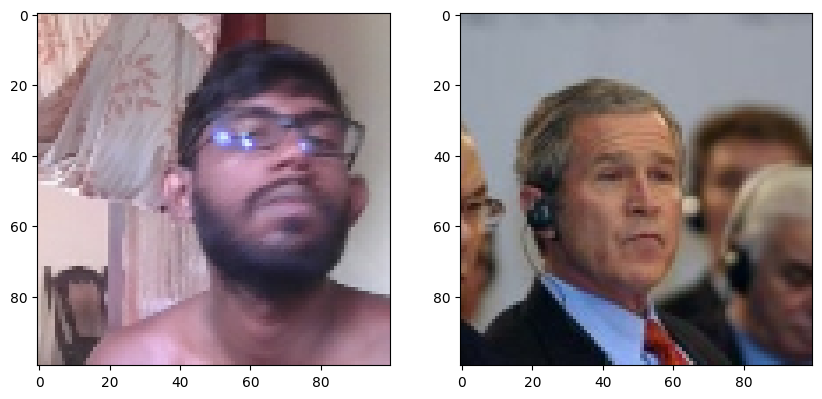

In [60]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[5])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[5])

plt.show()

In [62]:
# Save weights
siamese_model.save('siamesemodelv1.keras')

In [ ]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [63]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist (L1Dist)    │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      4,097 │ l1_dist[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [76]:
# opencv real-time verification
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250, 200:200+250, :]
    
    cv2.imshow('Verification', frame)

    # Wait for the key press
    key = cv2.waitKey(1) & 0XFF

    # Verify the image
    if key == ord('v'):
        # Save the image
        imgname = os.path.join('application_data', 'input_image', 'input_image.jpg')
        cv2.imwrite(imgname, frame)
        
        # Verify the image
        results, verified = verify(siamese_model, 0.5, 0.5)
        print("Verified: ", verified)

    # Breaking gracefully when 'q' is pressed
    if key == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━

KeyboardInterrupt: 